# Prelims

In [9]:
print('kernel running')

kernel running


In [10]:
%matplotlib inline

# path hack for relative import in jupyter notebook
import os
import sys

# LIBRARY GLOBAL MODS
ROOTDIR = os.path.dirname(os.path.abspath(''))
sys.path.append(ROOTDIR)

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

from model.batch import Batch, data_gen
from model.position import PositionalEncoding, subsequent_mask
from model.transformer import make_model
from util.greedy_decode import greedy_decode
from util.label_smoothing import LabelSmoothing
from util.noam_opt import NoamOpt
from util.run_epoch import run_epoch

from transformer_mini import data_gen_list, SimpleLossCompute

## Greedy Decoding block

In [22]:
# Train the simple copy task.
V = 11  # input symbols are integers from 1 to 11 inclusive
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)  # model is EncoderDecoder object
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Generate random data (to inspect the data only, note we are using batch size 20 inside the training loop)
example_data_batches = data_gen_list(V, 30, 5)  # old call: data_gen(V, 30, 20) (makes generator instead of list)
print('data_batches properties')
print(type(example_data_batches), 'lengths', len(example_data_batches), type(example_data_batches[0]))

# Train & test parameters
epochs = 15
nbatch_train = 20
nbatch_test = 5
sentence_len = 30
dataset_training = data_gen_list(V, sentence_len, nbatch_train)
dataset_testing = data_gen_list(V, sentence_len, nbatch_test)

# Train the model
loss_curve = [0] * epochs
loss_curve_test_frozen = [0] * epochs
loss_curve_test_random = [0] * epochs
for epoch in range(epochs):  # def 15
    ## calls nn.Module.train() which sets mode to train
    model.train()
    # data: generates nbatch_train batches of [sentence_len, 10] random integers (first column is 1)
    epoch_loss_train = run_epoch(dataset_training, model, 
                                 SimpleLossCompute(model.generator, criterion, model_opt))
    loss_curve[epoch] = epoch_loss_train.item()
    print('\nEpoch %d loss:' % epoch, epoch_loss_train.item())
    
    ## Layers like dropout behave differently depending on if mode is train or testing.
    model.eval()  # sets mode to testing (i.e. train=False).
    loss_curve_test_frozen[epoch] = run_epoch(dataset_testing, model, SimpleLossCompute(model.generator, criterion, None)).item()
    loss_curve_test_random[epoch] = run_epoch(data_gen(V, sentence_len, nbatch_test), model, SimpleLossCompute(model.generator, criterion, None)).item()
    print('test_performance (frozen,random):', loss_curve_test_frozen[epoch], loss_curve_test_random[epoch])


data_batches properties
<class 'list'> lengths 5 <class 'model.batch.Batch'>
Epoch Step: 1 Loss: 3.131577 Tokens per Sec: 444.440639

Epoch 0 loss: 2.4737708568573
Epoch Step: 1 Loss: 1.933056 Tokens per Sec: 624.278482
Epoch Step: 1 Loss: 1.851938 Tokens per Sec: 636.790983
test_performance (frozen,random): 1.866791844367981 1.8563814163208008
Epoch Step: 1 Loss: 2.004951 Tokens per Sec: 453.392523

Epoch 1 loss: 1.9754613637924194
Epoch Step: 1 Loss: 1.654213 Tokens per Sec: 630.842567
Epoch Step: 1 Loss: 1.595695 Tokens per Sec: 628.636928
test_performance (frozen,random): 1.600564956665039 1.632161259651184
Epoch Step: 1 Loss: 1.985201 Tokens per Sec: 444.807841

Epoch 2 loss: 1.8482035398483276
Epoch Step: 1 Loss: 1.288910 Tokens per Sec: 628.639894
Epoch Step: 1 Loss: 1.326385 Tokens per Sec: 625.723760
test_performance (frozen,random): 1.266371488571167 1.3325247764587402
Epoch Step: 1 Loss: 1.888201 Tokens per Sec: 450.037268

Epoch 3 loss: 1.8041417598724365
Epoch Step: 1 Loss

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

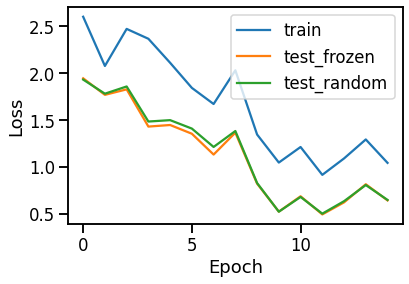

In [16]:
plt.plot(range(epochs), loss_curve, label='train')
plt.plot(range(epochs), loss_curve_test_frozen, label='test_frozen')
plt.plot(range(epochs), loss_curve_test_random, label='test_random')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [17]:
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  6,  7,  8, 10]])


In [18]:
src = Variable(torch.LongTensor([[1, 1, 3, 2, 9, 1, 7, 1, 9, 1]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 1, 1, 3, 9, 1, 7, 1, 9, 1]])


In [19]:
def greedy_decode_local(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    print('memory:', type(memory), memory.dim(), memory.shape)
    
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    print(ys)
    print(type(ys), ys.dim(), ys.shape)
    
    for i in range(max_len - 1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        print(ys)
        print(type(ys), ys.dim(), ys.shape)
        
    return ys

In [20]:
src = Variable(torch.LongTensor([[1, 1, 3, 2, 9, 1, 7, 1, 9, 1]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode_local(model, src, src_mask, max_len=10, start_symbol=1))

memory: <class 'torch.Tensor'> 3 torch.Size([1, 10, 512])
tensor([[1]])
<class 'torch.Tensor'> 2 torch.Size([1, 1])
tensor([[1, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 2])
tensor([[1, 1, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 3])
tensor([[1, 1, 1, 3]])
<class 'torch.Tensor'> 2 torch.Size([1, 4])
tensor([[1, 1, 1, 3, 9]])
<class 'torch.Tensor'> 2 torch.Size([1, 5])
tensor([[1, 1, 1, 3, 9, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 6])
tensor([[1, 1, 1, 3, 9, 1, 7]])
<class 'torch.Tensor'> 2 torch.Size([1, 7])
tensor([[1, 1, 1, 3, 9, 1, 7, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 8])
tensor([[1, 1, 1, 3, 9, 1, 7, 1, 9]])
<class 'torch.Tensor'> 2 torch.Size([1, 9])
tensor([[1, 1, 1, 3, 9, 1, 7, 1, 9, 1]])
<class 'torch.Tensor'> 2 torch.Size([1, 10])
tensor([[1, 1, 1, 3, 9, 1, 7, 1, 9, 1]])
